# Assignment 2: Ising Model

Hope you enjoyed the first assignment! This is the jupyter notebook for the second assingnment. In this notebook, we will: 

1) Initialise a system
2) Visualise the system 
3) Develop a spin flip algorithm and see how the system converges to the ground state 
4) Perform binning analysis for the single spin flip algorithm and evaluate the autocorrelation time 
5) Apply the Swendsen-Wang or Wolff algorithm for cluster flipping 
6) Perform binning analysis and evaluate the autocorrelation time for Swendsen-Wang/Wolff 
7) Compare single spin flip and Swendsen-Wang/Wolff
8) Find magnetisation as a function of temperature
9) Evaluate the standard error 
10) Find the autocorrelation time as a function of temperature 
11) Based on all of the above, find the critical temperature of the 2D Ising model 

While this is a lot, I will provide a good chunk of hints to make the process smoother. As previously stated, you will benefit more if you abstain from using LLMs here. At best it will only be useful to debug any cython errors.

Feel free to ask doubts in group or DMs! 

## 1. Initialise the system

As before, initialise a grid as a 2D array. This time, simply fill this array randomly with either -1 (down spin) or +1 (up spin). 

Hint: np.random.choice

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def init_system(n, m):
    return np.random.choice([1, -1], size=(n, m))

## 2. Visualise the grid and single spin flip algorithm 

Watch the following two youtube videos to get an introduction to cython. Conveniently, they are also about Ising model, so you are essentially getting this code for free 

https://www.youtube.com/watch?v=rN7g4gzO2sk&list=PLcKyTzEkOa-gxU14ehctpaQdhE2GOFpeb&index=1

https://www.youtube.com/watch?v=LOzcSuw3yOY


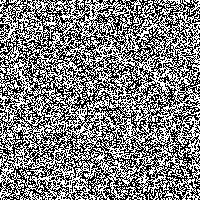

In [3]:
from PIL import Image

def display_spin_field(grid):
    return Image.fromarray(np.uint8((grid + 1) * 0.5 * 255))

test_to_viz = init_system(200, 200)
display_spin_field(test_to_viz)

In [5]:
# img = img.resize((img.width*10, img.height*10))

# img_rgb = img.convert("RGB")
# import matplotlib.pyplot as plt
# # Display the image with a larger figure size
# plt.figure(figsize=(5,5))  # Adjust this to scale up the display size
# plt.imshow(img_rgb)
# plt.axis('off')  # Turn off axis for a cleaner look
# plt.show()

In [6]:
def py_single_spin_flip_step(grid, beta=1, J=1):
    n, m = grid.shape

    for _ in range(n * m):
        i = np.random.randint(0, n)
        j = np.random.randint(0, m)

        delta_E = 2 * J * grid[i, j] * (
            grid[(i+1) % n, j] +
            grid[(i-1) % n, j] +
            grid[i, (j+1) % m] +
            grid[i, (j-1) % m]
        )

        if delta_E <= 0:
            grid[i, j] *= -1
        elif np.random.rand() < np.exp(-1 * beta * delta_E):
            grid[i, j] *= -1
    
    return grid.copy()

In [7]:
%load_ext Cython

In [8]:
%%cython
# cython: boundscheck=False, wraparound=False, cdivision=True
# cython: nonecheck=False, initializedcheck=False

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand, RAND_MAX

# first arg is long to match numpy's default numpy 64 bit
def single_spin_flip_step(np.int64_t[:, :] grid, float beta=1.0, int J=1):
    cdef int n = grid.shape[0]
    cdef int m = grid.shape[1]
    cdef float delta_E

    cdef int i, j
    for _ in range(n * m):
        i = <int>(rand() * (n / (RAND_MAX + 1.0)))
        j = <int>(rand() * (m / (RAND_MAX + 1.0)))


        delta_E = 2 * J * grid[i, j] * (
            grid[(i+1) % n, j] +
            grid[(i-1) % n, j] +
            grid[i, (j+1) % m] +
            grid[i, (j-1) % m]
        )

        if delta_E <= 0:
            grid[i, j] *= -1
        elif rand() < exp(-delta_E * beta) * RAND_MAX:
            grid[i, j] *= -1
    
    return np.array(grid)

In [9]:
ssf_time_test_py = init_system(200, 200)
ssf_time_test_cy = init_system(200, 200)

%timeit py_single_spin_flip_step(ssf_time_test_py)
%timeit single_spin_flip_step(ssf_time_test_cy, 200, 200)

154 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.42 ms ± 4.45 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
def single_spin_flip(grid, no_of_steps=1000, beta=1.0, J=1):
    n, m = grid.shape
    configs = []
    
    for _ in tqdm(range(no_of_steps)):
        configs.append(single_spin_flip_step(grid, beta=beta))

    return configs

100%|███████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 624.57it/s]


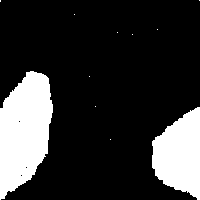

In [11]:
ssf_test_spins = init_system(200, 200)
ssf_configs = single_spin_flip(ssf_test_spins, beta=1.0)
display_spin_field(ssf_test_spins)

In [12]:
from ipywidgets import interact

def display_ising_seq(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [13]:
display_ising_seq(ssf_configs)

interactive(children=(IntSlider(value=499, description='frame', max=999), Output()), _dom_classes=('widget-int…

<function __main__.display_ising_seq.<locals>._show(frame=(0, 999))>

In [15]:
# img0 = display_spin_field(ssf_configs[0])
# img1 = display_spin_field(ssf_configs[-1])

# # Resize to something reasonable (e.g. 350x350)
# img0_small = img0.resize((350, 350), resample=Image.Resampling.NEAREST)
# img1_small = img1.resize((350, 350), resample=Image.Resampling.NEAREST)

# img0_small.save("ising_initial.png")
# img1_small.save("ising_equilibrated.png")

## 3. Implement the Swendsen-Wang/Wolff algorithm 

You will find a nice description of the Ising model and Swendsen-Wang/Wolff algorithm here.

https://csml.northwestern.edu/resources/Reprints/lnp_color.pdf

Implement only one out of Swendsen-Wang/Wolff, whichever is more comfortable to you. 

In [16]:
class DisjointSetPy:
    def __init__(self, size):
        self.parent = np.arange(size, dtype=int)
        self.rank = np.zeros(size, dtype=int)

    def find(self, label):
        root = label

        # climb up the tree
        while self.parent[root] != root:
            root = self.parent[root]

        # path compression
        while self.parent[label] != label:
            parent_label = self.parent[label]
            self.parent[label] = root
            label = parent_label

        return root

    def union(self, label1, label2):
        # ignore unoccupied
        if label1 == 0 or label2 == 0:
            return

        root1 = self.find(label1)
        root2 = self.find(label2)

        # ignore if labels already have same root
        if root1 == root2:
            return

        # union by rank
        if self.rank[root1] < self.rank[root2]:
            self.parent[root1] = root2
        elif self.rank[root1] > self.rank[root2]:
            self.parent[root2] = root1
        else:
            # same rank case
            self.parent[root2] = root1
            self.rank[root1] += 1


def py_swendsen_wang_step(grid, beta=1.0, J=1):
    n, m = grid.shape
    label = np.zeros(grid.shape, dtype=int)
    largest_label = 0
    disjoint_set = DisjointSetPy(n * m + 1)
    threshold = 1 - np.exp(-2 * beta * J)

    for i in range(n):
        for j in range(m):
            spin = grid[i, j]
            # check if there's a bond above
            if i == 0:
                above = 0
            elif spin == grid[i-1, j]:
                above = label[i-1, j] if np.random.rand() < threshold else 0
            else:
                above = 0
            # check if there's a bond on the left
            if j == 0:
                left = 0
            elif spin == grid[i, j-1]:
                left = label[i, j-1] if np.random.rand() < threshold else 0
            else:
                left = 0

            if left == 0 and above == 0:
                largest_label += 1
                label[i, j] = largest_label
            elif left != 0 and above == 0:
                label[i, j] = disjoint_set.find(left)
            elif left == 0 and above != 0:
                label[i, j] = disjoint_set.find(above)
            elif left != 0 and above != 0:
                disjoint_set.union(left, above)
                label[i, j] = disjoint_set.find(above)

    # periodic boundary
    # top-bottom
    for j in range(m):
        if grid[0, j] == grid[n - 1, j] and np.random.rand() < threshold:
            disjoint_set.union(label[0, j], label[n - 1, j])
    # left-right
    for i in range(n):
        if grid[i, 0] == grid[i, m - 1] and np.random.rand() < threshold:
            disjoint_set.union(label[i, 0], label[i, m - 1])

    # final pass
    for i in range(n):
        for j in range(m):
            if label[i, j] != 0:
                label[i, j] = disjoint_set.find(label[i, j])

    # flip
    unique_labels, inv = np.unique(label, return_inverse=True)
    should_flip = np.random.rand(unique_labels.size) < 0.5
    flip_factor = np.where(should_flip, -1, 1)
    grid *= flip_factor[inv].reshape(label.shape)

    return grid

In [17]:
%%cython
# cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand, RAND_MAX

ctypedef np.int64_t DTYPE_int

cdef class CyDisjointSet:
    cdef DTYPE_int[:] parent
    cdef DTYPE_int[:] rank
    
    def __init__(self, DTYPE_int size):
        self.parent = np.arange(size, dtype=np.int64)
        self.rank = np.zeros(size, dtype=np.int64)

    cdef DTYPE_int find(self, DTYPE_int label):
        cdef DTYPE_int root = label
        cdef DTYPE_int parent_label
        
        while self.parent[root] != root:
            root = self.parent[root]
        
        while self.parent[label] != label:
            parent_label = self.parent[label]
            self.parent[label] = root
            label = parent_label
            
        return root

    cdef void union(self, DTYPE_int label1, DTYPE_int label2):
        if label1 == 0 or label2 == 0:
            return

        cdef DTYPE_int root1 = self.find(label1)
        cdef DTYPE_int root2 = self.find(label2)

        if root1 == root2:
            return

        if self.rank[root1] < self.rank[root2]:
            self.parent[root1] = root2
        elif self.rank[root1] > self.rank[root2]:
            self.parent[root2] = root1
        else:
            self.parent[root2] = root1
            self.rank[root1] += 1

def swendsen_wang_step(DTYPE_int[:, :] grid, float beta=1.0, int J=1):
    cdef Py_ssize_t n = grid.shape[0]
    cdef Py_ssize_t m = grid.shape[1]
    
    cdef DTYPE_int[:, :] label = np.zeros((n, m), dtype=np.int64)
    
    cdef CyDisjointSet disjoint_set = CyDisjointSet(n * m + 1)
    
    cdef DTYPE_int largest_label = 0
    cdef Py_ssize_t i, j, k
    cdef DTYPE_int spin, above, left
    
    cdef int threshold = <int>((1 - exp(-2 * beta * J)) * RAND_MAX)

    for i in range(n):
        for j in range(m):
            spin = grid[i, j]
            
            if i == 0:
                above = 0
            elif spin == grid[i-1, j]:
                if rand() < threshold:
                    above = label[i-1, j]
                else:
                    above = 0
            else:
                above = 0
            
            if j == 0:
                left = 0
            elif spin == grid[i, j-1]:
                if rand() < threshold:
                    left = label[i, j-1]
                else:
                    left = 0
            else:
                left = 0

            if left == 0 and above == 0:
                largest_label += 1
                label[i, j] = largest_label
            elif left != 0 and above == 0:
                label[i, j] = disjoint_set.find(left)
            elif left == 0 and above != 0:
                label[i, j] = disjoint_set.find(above)
            elif left != 0 and above != 0:
                disjoint_set.union(left, above)
                label[i, j] = disjoint_set.find(above)

    # to make periodic boundaries
    for j in range(m):
        if grid[0, j] == grid[n - 1, j] and rand() < threshold:
            disjoint_set.union(label[0, j], label[n - 1, j])
    for i in range(n):
        if grid[i, 0] == grid[i, m - 1] and rand() < threshold:
            disjoint_set.union(label[i, 0], label[i, m - 1])

    # final pass
    for i in range(n):
        for j in range(m):
            label[i, j] = disjoint_set.find(label[i, j])
            
    # flip
    cdef int[:] flip_decisions = np.zeros(largest_label + 1, dtype=np.int32)

    for k in range(1, largest_label + 1):
        if rand() < (RAND_MAX / 2):
            flip_decisions[k] = 1
  
    for i in range(n):
        for j in range(m):
            if flip_decisions[label[i, j]] == 1:
                grid[i, j] *= -1

    return np.asarray(grid)

In [18]:
sw_time_test_py = init_system(200, 200)
sw_time_test_cy = init_system(200, 200).astype(np.int64)

%timeit py_swendsen_wang_step(sw_time_test_py)
%timeit swendsen_wang_step(sw_time_test_cy, beta=1.0, J=1)

67.5 ms ± 400 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.28 ms ± 6.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
def swendsen_wang(spins, no_of_steps=100, beta=1, J=1):
    n, m = spins.shape
    configs = []
    for i in tqdm(range(no_of_steps)):
        spins = swendsen_wang_step(spins, beta, J)
        configs.append(spins.copy())

    return configs

100%|█████████████████████████████████████████████████████| 100/100 [00:00<00:00, 663.00it/s]


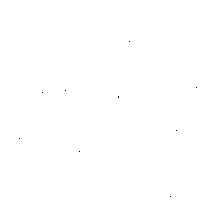

In [20]:
sw_test_spins = init_system(200, 200)
sw_configs = swendsen_wang(sw_test_spins, beta=1.0)
display_spin_field(sw_test_spins)

In [21]:
display_ising_seq(sw_configs)

interactive(children=(IntSlider(value=49, description='frame', max=99), Output()), _dom_classes=('widget-inter…

<function __main__.display_ising_seq.<locals>._show(frame=(0, 99))>

## 4. Autocorrelation error and time 

Perform a binning analysis of both Swendsen-Wang/Wolff (whichever you did) and single spin flip algorithm. Watch A6 from the lecture series below 

https://www.thp.uni-koeln.de/trebst/Lectures/2025-CompManyBody.shtml

Find the appropriate binning level by evaluating the standard error of magnetisation as a function of the binning level. It should very roughly saturate at a certain binning level (if you bin too much, it will go haywire again. you will see what i mean if you try that; think about why this is happening)

In [22]:
def ssf_magnetisation(spins, no_of_steps, beta=1.0, J=1, use_abs=True):
    spins = spins.copy()
    A = np.empty(no_of_steps, dtype=np.float64)
    
    for t in tqdm(range(no_of_steps)):
        spins = single_spin_flip_step(spins, beta=beta, J=J)
        A_t = spins.mean()
        A[t] = abs(A_t) if use_abs else A_t
    
    return A

def sw_magnetisation(spins, no_of_steps, beta=1.0, J=1, use_abs=True):
    spins = spins.copy()
    A = np.empty(no_of_steps, dtype=np.float64)
    
    for t in tqdm(range(no_of_steps)):
        spins = swendsen_wang_step(spins, beta=beta, J=J)
        A_t = spins.mean()
        A[t] = abs(A_t) if use_abs else A_t
    
    return A

In [23]:
def binning(A):
    A = np.asarray(A, dtype=np.float64)

    levels = []
    stderr = []
    n_eff = []

    level = 0
    curr_A = A.copy()

    while curr_A.size >= 2:
        n = curr_A.size
        mean = curr_A.mean()
        s2 = curr_A.var(ddof=1)
        se = np.sqrt(s2 / n)
        levels.append(level)
        stderr.append(se)
        n_eff.append(n)

        if n % 2 == 1:
            curr_A = curr_A[:-1]
            n -= 1
        curr_A = 0.5 * (curr_A[0::2] + curr_A[1::2])

        level += 1

    return np.array(levels), np.array(stderr), np.array(n_eff)

In [24]:
import matplotlib.pyplot as plt

def plot_binning(A, title="", filename="binning.png"):
    results = []
    plt.figure()
    for label, series in A:
        levels, se, n_eff = binning(series)
        plt.plot(levels, se, marker="o", label=str(label))
        results.append((label, levels, se, n_eff))
    plt.xlabel("Binning level l")
    plt.ylabel("Standard error")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    # plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.show()
    return results

100%|███████████████████████████████████████████| 2000000/2000000 [00:31<00:00, 63925.36it/s]


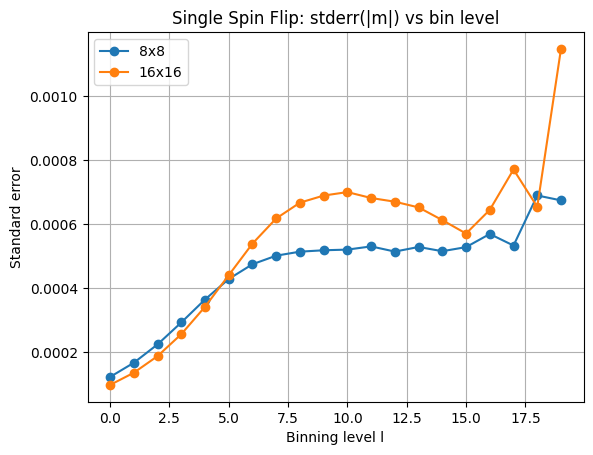

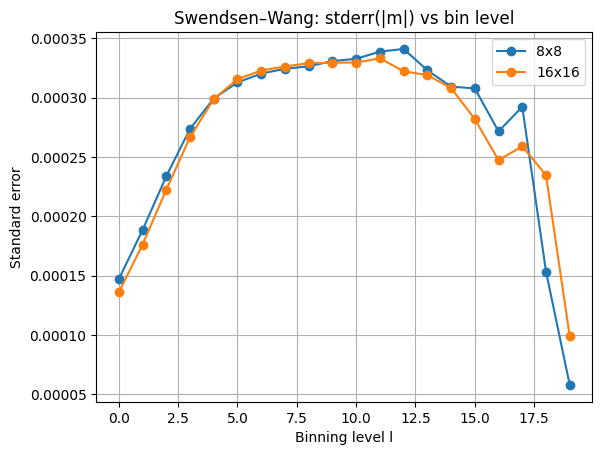

[('8x8',
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19]),
  array([1.47012232e-04, 1.88350569e-04, 2.33788385e-04, 2.73737098e-04,
         2.99318495e-04, 3.12893143e-04, 3.20325401e-04, 3.24386845e-04,
         3.26492813e-04, 3.30901021e-04, 3.32810909e-04, 3.38861770e-04,
         3.41151641e-04, 3.23151224e-04, 3.09370057e-04, 3.07828801e-04,
         2.71625203e-04, 2.92334223e-04, 1.53384058e-04, 5.77385469e-05]),
  array([2000000, 1000000,  500000,  250000,  125000,   62500,   31250,
           15625,    7812,    3906,    1953,     976,     488,     244,
             122,      61,      30,      15,       7,       3])),
 ('16x16',
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19]),
  array([1.35786182e-04, 1.76073758e-04, 2.22413263e-04, 2.66715340e-04,
         2.98861173e-04, 3.15601048e-04, 3.22941092e-04, 3.26322847e-04,
         3.29128890e-04, 3.29515554e-04, 3.29681726e-04, 

In [25]:
sizes = [(8, 8), (16, 16)]
beta = 0.44
steps = 2000000
J = 1

ssf_series = []
sw_series = []

for n, m in sizes:
    spins = init_system(n, m).astype(np.int64)
    ssf_series.append((f"{n}x{m}", ssf_magnetisation(spins, no_of_steps=steps, beta=beta, J=J)))
    sw_series.append((f"{n}x{m}", sw_magnetisation(spins, no_of_steps=steps, beta=beta, J=J)))

plot_binning(ssf_series, title="Single Spin Flip: stderr(|m|) vs bin level", filename="ssf_binning.png")
plot_binning(sw_series, title="Swendsen–Wang: stderr(|m|) vs bin level", filename="sw_binning.png")

## 5. Compare the two flipping algorithms

Plot the magnetisation (Sum over the spins, and divide by the size of the system) as a function of number of iterations. Do this for a low temperature. which method converges faster? 

100%|██████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 7210.39it/s]


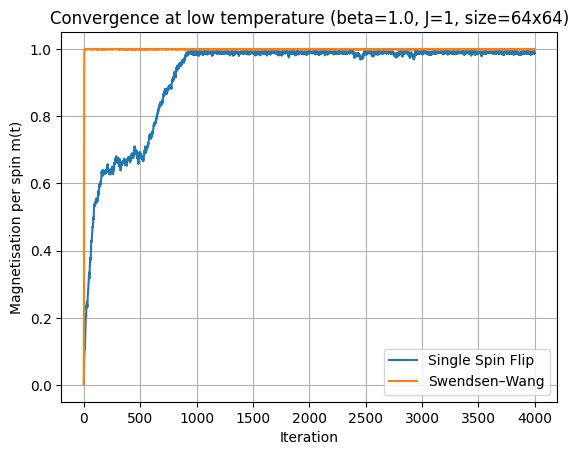

In [29]:
import matplotlib.pyplot as plt

n, m = 64, 64
beta = 1.0
J = 1
iters = 4000

init = init_system(n, m).astype(np.int64)
M_ssf = ssf_magnetisation(init, no_of_steps=iters, beta=beta, J=J, use_abs=True)
M_sw  = sw_magnetisation(init, no_of_steps=iters, beta=beta, J=J, use_abs=True)

plt.figure()
plt.plot(M_ssf, label="Single Spin Flip")
plt.plot(M_sw,  label="Swendsen–Wang")
plt.xlabel("Iteration")
plt.ylabel("Magnetisation per spin m(t)")
plt.title(f"Convergence at low temperature (beta={beta}, J={J}, size={n}x{m})")
plt.legend()
plt.grid(True)
plt.savefig("convergence_lowT.png", dpi=200, bbox_inches="tight")
plt.show()

## 6. Magnetisation v/s temperature 

Plot magnetisation as a function of temperature for three different lattice sizes, say 8,10 and 12.

In [30]:
def abs_magnetisation_per_spin(spins):
    return abs(spins.mean())

def ssf_avg_abs_magnetisation(L, T, n_therm=5000, n_meas=10000, J=1, seed=None):
    beta = 1.0 / T
    spins = init_system(L, L).astype(np.int64)

    for _ in range(n_therm):
        spins = single_spin_flip_step(spins, beta=beta, J=J)

    m_series = np.empty(n_meas, dtype=np.float64)
    for t in range(n_meas):
        spins = single_spin_flip_step(spins, beta=beta, J=J)
        m_series[t] = abs_magnetisation_per_spin(spins)

    return m_series.mean()

def sw_avg_abs_magnetisation(L, T, n_therm=300, n_meas=2000, J=1, seed=None):
    beta = 1.0 / T
    spins = init_system(L, L).astype(np.int64)

    for _ in range(n_therm):
        spins = swendsen_wang_step(spins, beta=beta, J=J)

    m_series = np.empty(n_meas, dtype=np.float64)
    for t in range(n_meas):
        spins = swendsen_wang_step(spins, beta=beta, J=J)
        m_series[t] = abs_magnetisation_per_spin(spins)

    return m_series.mean()

In [39]:
Ls = [8, 10, 12]
# T_c = 2.269
T_values = np.linspace(1.5, 3.5, 25)
J = 1

mag_vs_T_ssf = {}
mag_vs_T_sw = {}

for L in Ls:
    M_ssf = []
    M_sw = []
    for T in tqdm(T_values):
        M_ssf.append(ssf_avg_abs_magnetisation(L, T, n_therm=8000, n_meas=15000, J=J))
        M_sw.append(sw_avg_abs_magnetisation(L, T, n_therm=300, n_meas=2000, J=J))

    mag_vs_T_ssf[L] = np.array(M_ssf)
    mag_vs_T_sw[L] = np.array(M_sw)

100%|████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.32it/s]


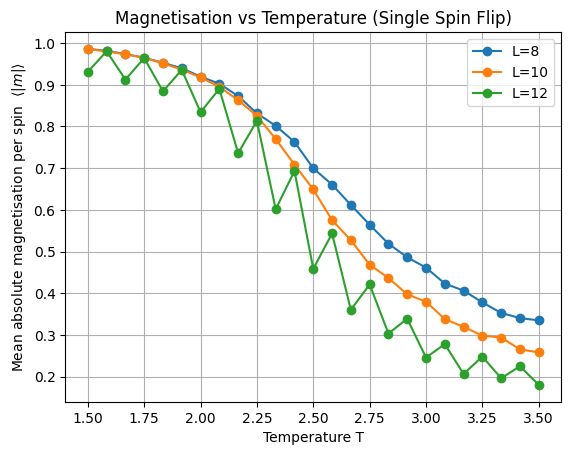

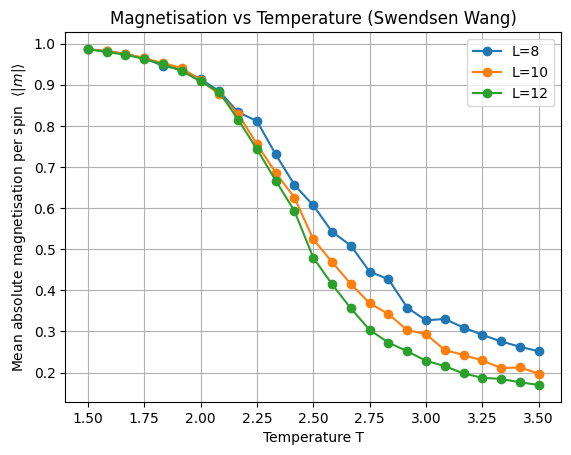

In [40]:
methods = {"Single Spin Flip": mag_vs_T_ssf, "Swendsen Wang": mag_vs_T_sw}
for method_name, results in methods.items():
    plt.figure()
    for L in Ls:
        plt.plot(T_values, results[L], marker="o", label=f"L={L}")
    plt.xlabel("Temperature T")
    plt.ylabel(r"Mean absolute magnetisation per spin  $\langle |m| \rangle$")
    plt.title(f"Magnetisation vs Temperature ({method_name})")
    plt.legend()
    plt.grid(True)

    filename = ""
    if method_name == "Single Spin Flip":
        filename = "magnetisation_vs_temperature_metropolis.png"
    elif method_name == "Swendsen Wang":
        filename = "magnetisation_vs_temperature_sw.png"

    plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.show()

## 7. Autocorrelation time v/s temperature 

Find the autocorrelation time as a function of temperature for both the cluster flipping algorithms (single spin and Swendsen-Wang/Wolff). Which algortihm has a longer autocorrelation time? Is the result expected? Based on magnetisation v/s temperature and autocorrelation time v/s temperature, can you identify the critical temperature (this is harder than percolation theory as your graphs will be noisier, it is fine if it is a bit off)

In [41]:
def abs_m_per_spin(spins):
    return abs(spins.mean())

def series_abs_m_ssf(L, T, n_therm=5000, n_meas=30000, J=1):
    beta = 1.0 / T
    spins = init_system(L, L).astype(np.int64)

    # thermalize
    for _ in range(n_therm):
        spins = single_spin_flip_step(spins, beta=beta, J=J)

    # measure
    x = np.empty(n_meas, dtype=np.float64)
    for t in range(n_meas):
        spins = single_spin_flip_step(spins, beta=beta, J=J)
        x[t] = abs_m_per_spin(spins)

    return x

def series_abs_m_sw(L, T, n_therm=300, n_meas=8000, J=1):
    beta = 1.0 / T
    spins = init_system(L, L).astype(np.int64)

    # thermalize
    for _ in range(n_therm):
        spins = swendsen_wang_step(spins, beta=beta, J=J)

    # measure
    x = np.empty(n_meas, dtype=np.float64)
    for t in range(n_meas):
        spins = swendsen_wang_step(spins, beta=beta, J=J)
        x[t] = abs_m_per_spin(spins)

    return x

In [42]:
def autocorr_fft(x):
    x = np.asarray(x, dtype=np.float64)
    n = x.size
    x = x - x.mean()

    f = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(f * np.conjugate(f))[:n]
    acf /= acf[0]
    return acf

def tau_int_window(rho, c=6.0):
    tau = 0.5
    for t in range(1, len(rho)):
        tau_new = tau + rho[t]
        if t > c * tau_new:
            return tau_new
        tau = tau_new
    return tau


In [43]:
def compute_tau_vs_T(L, T_values, J=1,
                     therm_ssf=8000, meas_ssf=40000,
                     therm_sw=500,  meas_sw=12000,
                     c_window=6.0):
    tau_ssf = []
    tau_sw = []

    for T in tqdm(T_values):
        x_ssf = series_abs_m_ssf(L, T, n_therm=therm_ssf, n_meas=meas_ssf, J=J)
        rho_ssf = autocorr_fft(x_ssf)
        tau_ssf.append(tau_int_window(rho_ssf, c=c_window))

        x_sw = series_abs_m_sw(L, T, n_therm=therm_sw, n_meas=meas_sw, J=J)
        rho_sw = autocorr_fft(x_sw)
        tau_sw.append(tau_int_window(rho_sw, c=c_window))

    return np.array(tau_ssf), np.array(tau_sw)


In [44]:
def estimate_Tc_from_tau_peak(T_values, tau_values):
    idx = np.argmax(tau_values)
    return T_values[idx]

def estimate_Tc_from_mag_slope(T_values, M_values):
    dMdT = np.gradient(M_values, T_values)
    idx = np.argmin(dMdT)
    return T_values[idx]

In [47]:
L = 12
J = 1
T_true = 2.269185

# T_values = np.linspace(1.5, 3.5, 18)
T_values = np.linspace(1.5, 3.5, 36)

def mean_abs_m_curve_ssf(L, T_values, J=1, n_therm=10000, n_meas=40000):
    M = []
    for T in T_values:
        x = series_abs_m_ssf(L, T, n_therm=n_therm, n_meas=n_meas, J=J)
        M.append(x.mean())
    return np.array(M)

def mean_abs_m_curve_sw(L, T_values, J=1, n_therm=300, n_meas=8000):
    M = []
    for T in T_values:
        x = series_abs_m_sw(L, T, n_therm=n_therm, n_meas=n_meas, J=J)
        M.append(x.mean())
    return np.array(M)

tau_ssf, tau_sw = compute_tau_vs_T(L, T_values, J=J)

M_ssf = mean_abs_m_curve_ssf(L, T_values, J=J)
M_sw  = mean_abs_m_curve_sw(L, T_values, J=J)

Tc_est_tau_ssf = estimate_Tc_from_tau_peak(T_values, tau_ssf)
Tc_est_tau_sw  = estimate_Tc_from_tau_peak(T_values, tau_sw)

Tc_est_mag_ssf = estimate_Tc_from_mag_slope(T_values, M_ssf)
Tc_est_mag_sw  = estimate_Tc_from_mag_slope(T_values, M_sw)

print("Tc estimates from tau_int peak:")
print("Single Spin Flip:", Tc_est_tau_ssf)
print("Swendsen Wang:", Tc_est_tau_sw)

print("\nTc estimates from steepest drop in <|m|>(T):")
print("Single Spin Flip:", Tc_est_mag_ssf)
print("Swendsen Wang:", Tc_est_mag_sw)

100%|████████████████████████████████████████████████████████| 36/36 [00:18<00:00,  1.99it/s]


Tc estimates from tau_int peak:
Single Spin Flip: 2.414285714285714
Swendsen Wang: 2.3

Tc estimates from steepest drop in <|m|>(T):
Single Spin Flip: 2.5285714285714285
Swendsen Wang: 2.3


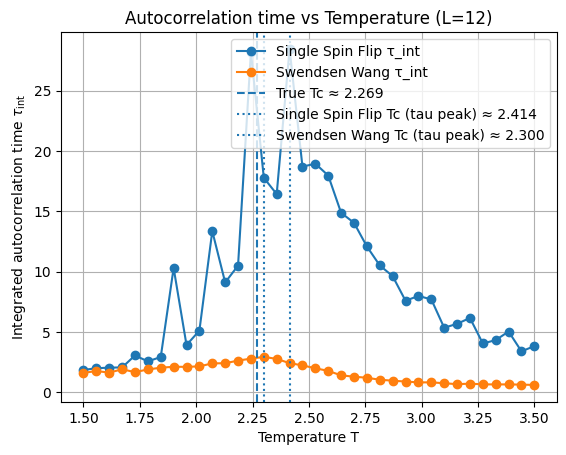

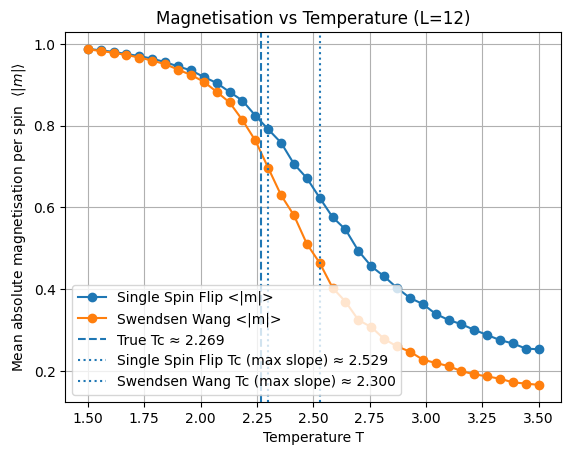

In [48]:
plt.figure()
plt.plot(T_values, tau_ssf, marker="o", label="Single Spin Flip τ_int")
plt.plot(T_values, tau_sw,  marker="o", label="Swendsen Wang τ_int")

plt.axvline(T_true, linestyle="--", label=f"True Tc ≈ {T_true:.3f}")

plt.axvline(Tc_est_tau_ssf, linestyle=":", label=f"Single Spin Flip Tc (tau peak) ≈ {Tc_est_tau_ssf:.3f}")
plt.axvline(Tc_est_tau_sw,  linestyle=":", label=f"Swendsen Wang Tc (tau peak) ≈ {Tc_est_tau_sw:.3f}")

plt.xlabel("Temperature T")
plt.ylabel(r"Integrated autocorrelation time $\tau_{\mathrm{int}}$")
plt.title(f"Autocorrelation time vs Temperature (L={L})")
plt.grid(True)
plt.legend()
plt.grid(True)
plt.savefig("tauint_vs_temperature.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(T_values, M_ssf, marker="o", label="Single Spin Flip <|m|>")
plt.plot(T_values, M_sw,  marker="o", label="Swendsen Wang <|m|>")

plt.axvline(T_true, linestyle="--", label=f"True Tc ≈ {T_true:.3f}")

plt.axvline(Tc_est_mag_ssf, linestyle=":", label=f"Single Spin Flip Tc (max slope) ≈ {Tc_est_mag_ssf:.3f}")
plt.axvline(Tc_est_mag_sw,  linestyle=":", label=f"Swendsen Wang Tc (max slope) ≈ {Tc_est_mag_sw:.3f}")

plt.xlabel("Temperature T")
plt.ylabel(r"Mean absolute magnetisation per spin  $\langle |m| \rangle$")
plt.title(f"Magnetisation vs Temperature (L={L})")
plt.legend()
plt.grid(True)
plt.savefig("magnetisation_vs_temperature_Tc_lines.png", dpi=200, bbox_inches="tight")
plt.show()

## 8. Specific heat 

Find the specific heat as a function of temperature for different lattice sizes, say 8,12 and 16. Use the following formula for specific heat 

$$C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{NT^2}  $$

Do you see the phase transition? 

In [49]:
def energy_ising(spins, J=1):
    s = spins
    E = -J * np.sum(s * np.roll(s, shift=-1, axis=0) +
                   s * np.roll(s, shift=-1, axis=1))
    return E

In [50]:
def cv_vs_T_ssf(L, T_values, n_therm=5000, n_meas=20000, J=1):
    N = L * L
    spins = init_system(L, L).astype(np.int64)

    Cv = []

    for T in tqdm(T_values, desc=f'SSF CV vs T for L = {L}'):
        beta = 1.0 / T

        for _ in range(n_therm):
            spins = single_spin_flip_step(spins, beta=beta, J=J)

        E_series = np.empty(n_meas, dtype=np.float64)
        for t in range(n_meas):
            spins = single_spin_flip_step(spins, beta=beta, J=J)
            E_series[t] = energy_ising(spins, J=J)

        E_mean = E_series.mean()
        E2_mean = (E_series**2).mean()

        Cv.append((E2_mean - E_mean**2) / (N * T**2))

    return np.array(Cv)


In [51]:
def cv_vs_T_sw(L, T_values, n_therm=300, n_meas=8000, J=1):
    N = L * L
    spins = init_system(L, L).astype(np.int64)

    Cv = []

    for T in tqdm(T_values, desc=f'SW CV vs T for L = {L}'):
        beta = 1.0 / T

        for _ in range(n_therm):
            spins = swendsen_wang_step(spins, beta=beta, J=J)

        E_series = np.empty(n_meas, dtype=np.float64)
        for t in range(n_meas):
            spins = swendsen_wang_step(spins, beta=beta, J=J)
            E_series[t] = energy_ising(spins, J=J)

        E_mean = E_series.mean()
        E2_mean = (E_series**2).mean()

        Cv.append((E2_mean - E_mean**2) / (N * T**2))

    return np.array(Cv)


In [52]:
T_true = 2.269185

T_values = np.linspace(1.5, 3.5, 32)

Ls = [8, 12, 16]
J = 1

Cv_ssf_dict = {}
Cv_sw_dict = {}

for L in Ls:
    Cv_ssf_dict[L] = cv_vs_T_ssf(L, T_values, n_therm=5000, n_meas=20000, J=J)
    Cv_sw_dict[L]  = cv_vs_T_sw(L, T_values, n_therm=300, n_meas=8000, J=J)

def estimate_Tc_from_Cv_peak(T_values, Cv_values):
    idx = np.argmax(Cv_values)
    return T_values[idx], Cv_values[idx]

Tc_ssf = {}
Tc_sw = {}

for L in Ls:
    Tc_ssf[L] = estimate_Tc_from_Cv_peak(T_values, Cv_ssf_dict[L])
    Tc_sw[L] = estimate_Tc_from_Cv_peak(T_values, Cv_sw_dict[L])

print("Estimated Tc from Cv peak (Single Spin Flip):")
for L in Ls:
    print(f"  L={L}: Tc ≈ {Tc_ssf[L][0]:.4f}, Cv_peak ≈ {Tc_ssf[L][1]:.4f}")

print("\nEstimated Tc from Cv peak (Swendsen–Wang):")
for L in Ls:
    print(f"  L={L}: Tc ≈ {Tc_sw[L][0]:.4f}, Cv_peak ≈ {Tc_sw[L][1]:.4f}")

SW CV vs T for L = 16: 100%|█████████████████████████████████| 32/32 [00:06<00:00,  4.85it/s]

Estimated Tc from Cv peak (Single Spin Flip):
  L=8: Tc ≈ 2.4677, Cv_peak ≈ 1.0303
  L=12: Tc ≈ 2.3387, Cv_peak ≈ 1.2868
  L=16: Tc ≈ 2.2097, Cv_peak ≈ 1.6547

Estimated Tc from Cv peak (Swendsen–Wang):
  L=8: Tc ≈ 2.4032, Cv_peak ≈ 1.1807
  L=12: Tc ≈ 2.2742, Cv_peak ≈ 1.3668
  L=16: Tc ≈ 2.3387, Cv_peak ≈ 1.5264


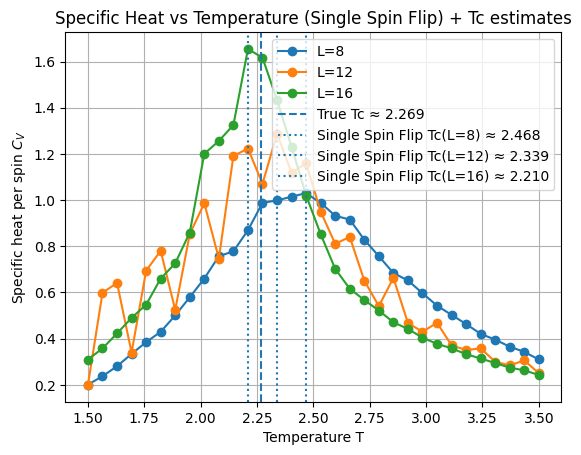

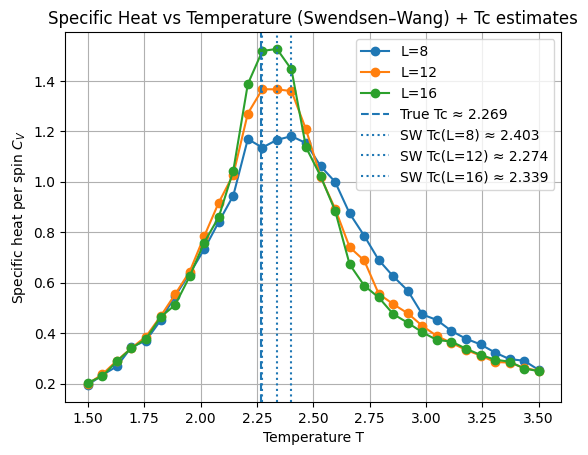

In [53]:
plt.figure()

for L in Ls:
    plt.plot(T_values, Cv_ssf_dict[L], marker="o", label=f"L={L}")

plt.axvline(T_true, linestyle="--", label=f"True Tc ≈ {T_true:.3f}")

for L in Ls:
    Tc_est = Tc_ssf[L][0]
    plt.axvline(Tc_est, linestyle=":", label=f"Single Spin Flip Tc(L={L}) ≈ {Tc_est:.3f}")

plt.xlabel("Temperature T")
plt.ylabel(r"Specific heat per spin $C_V$")
plt.title("Specific Heat vs Temperature (Single Spin Flip) + Tc estimates")
plt.legend()
plt.grid(True)
plt.savefig("cv_vs_temperature_metropolis.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure()

for L in Ls:
    plt.plot(T_values, Cv_sw_dict[L], marker="o", label=f"L={L}")

plt.axvline(T_true, linestyle="--", label=f"True Tc ≈ {T_true:.3f}")

for L in Ls:
    Tc_est = Tc_sw[L][0]
    plt.axvline(Tc_est, linestyle=":", label=f"SW Tc(L={L}) ≈ {Tc_est:.3f}")

plt.xlabel("Temperature T")
plt.ylabel(r"Specific heat per spin $C_V$")
plt.title("Specific Heat vs Temperature (Swendsen–Wang) + Tc estimates")
plt.legend()
plt.grid(True)
plt.savefig("cv_vs_temperature_sw.png", dpi=200, bbox_inches="tight")
plt.show()

## 8. Bonus 1: The XY model

In XY model, the spins are a 2D unit vector. Perform the same procedure as above, for only Swendsen-Wang/Wolff algorithm. Is the phase transition looking weird? 

Hint: Evaluate the specific heat v/s temperature plot

## 9 Bonus 2: Unsupervised Learning

Here we are going to use a method called Principal Component Analysis (PCA). We will use the function sklearn.decomposition.PCA 

Find out what PCA does by looking up this function's documentation. Take a random value of temperature from 1.6 to 3, and initialise a system. Let it reach the equilibrium, by letting it evolve by doing 500 Swendsen-Wang/Wolff cluster flips. Flatten each of these 500 equilibriated systems into 1D arrays, and append these arrays together, creating an array which consists of 500 arrays. Keep track of what is the temperature these systems were equilibriated at in a separate 1D array. 

Perform PCA of this data. Plot the first and the second component of PCA against each other, and label the scatter plots with temperature. What do you see? Can you differentiate between the magnetised and non-magnetised state? Why is this happening, what do these principal components represent? 